# From Points to Paths

In [1]:
import pandas as pd 
import geopandas as gpd 
import movingpandas as mpd 
import matplotlib.pyplot as plt
import contextily as ctx
from datetime import datetime, timedelta
from geopandas.tools import reverse_geocode, geocode
import warnings
warnings.filterwarnings('ignore')

In [55]:
def t_plot(traj, 
            figsize=(6,8), 
            source=ctx.providers.CartoDB.Voyager, 
            title=None):
    f, ax = plt.subplots(figsize=figsize)
    traj.plot(ax=ax, lw=4, color='chartreuse')
    ctx.add_basemap(ax, crs=traj.crs, 
                    source=source)
    ax.set_axis_off()
    if title: 
        ax.set_title(title)
    else:
        ax.set_title(f'Walk in {traj.df.Name[0]} on {traj.df.index[0].strftime('%x')}')
    return f, ax

In [3]:
annot_props = dict(
    xytext=(3, 1), 
    textcoords="offset fontsize", 
    c='r', weight='bold', ha='center',
    arrowprops=dict(arrowstyle='-', ec='orange')
)

## CSV to GDF

In [4]:
df = pd.read_csv('data/b3/combined.csv')
gdf = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(x=df.Lon, y=df.Lat), 
    crs=4269
).to_crs(32111)

In [5]:
idList = list(gdf.groupby(['Id']).nunique().reset_index().Id)
for i, track in enumerate(idList):
    gdf.loc[gdf.Id == track, 'trajectory_id'] = i

gdf['Time'] = pd.to_datetime(gdf.Time)
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3044 entries, 0 to 3043
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   Id             3044 non-null   object             
 1   Name           3044 non-null   object             
 2   Lat            3044 non-null   float64            
 3   Lon            3044 non-null   float64            
 4   Elev           3044 non-null   int64              
 5   Time           3044 non-null   datetime64[ns, UTC]
 6   Temp           3044 non-null   float64            
 7   Weather        3044 non-null   int64              
 8   geometry       3044 non-null   geometry           
 9   trajectory_id  3044 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(4), geometry(1), int64(2), object(2)
memory usage: 237.9+ KB


In [6]:
gdf.crs

<Projected CRS: EPSG:32111>
Name: NAD83 / New Jersey
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - New Jersey - counties of Atlantic; Bergen; Burlington; Camden; Cape May; Cumberland; Essex; Gloucester; Hudson; Hunterdon; Mercer; Middlesex; Monmouth; Morris; Ocean; Passaic; Salem; Somerset; Sussex; Union; Warren.
- bounds: (-75.6, 38.87, -73.88, 41.36)
Coordinate Operation:
- name: SPCS83 New Jersey zone (meter)
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [7]:
gdf_nj = gdf.loc[gdf.Name != 'New York']
gdf_ny = gdf.loc[gdf.Name == 'New York']
gdf_nj.shape, gdf_ny.shape

((2063, 10), (981, 10))

## Trajectories and Trajectory Collections

In [8]:
tc_nj = mpd.TrajectoryCollection(
    gdf_nj, 'trajectory_id', 
    t='Time', x='Lon', y='Lat'
)
print(tc_nj)

TrajectoryCollection with 6 trajectories


In [9]:
print(tc_nj.get_start_locations().head(1))

                     Time                           Id        Name        Lat  \
0 2024-09-05 15:25:13.004  Workout-2024-09-05-15-25-13  Park Ridge  41.043858   

         Lon Elev   Temp Weather                      geometry trajectory_id  
0 -74.063712   79  20.51       0  POINT (186679.21 245509.399)           0.0  


In [10]:
print(tc_nj.get_end_locations().head(1))

                     Time                           Id        Name        Lat  \
0 2024-09-05 16:59:23.047  Workout-2024-09-05-15-25-13  Park Ridge  41.032801   

         Lon Elev   Temp Weather                       geometry trajectory_id  
0 -74.034278   22  20.51       0  POINT (189160.319 244294.375)           0.0  


In [11]:
print(tc_nj.get_column_names())

Index(['Id', 'Name', 'Lat', 'Lon', 'Elev', 'Temp', 'Weather', 'geometry',
       'trajectory_id'],
      dtype='object')


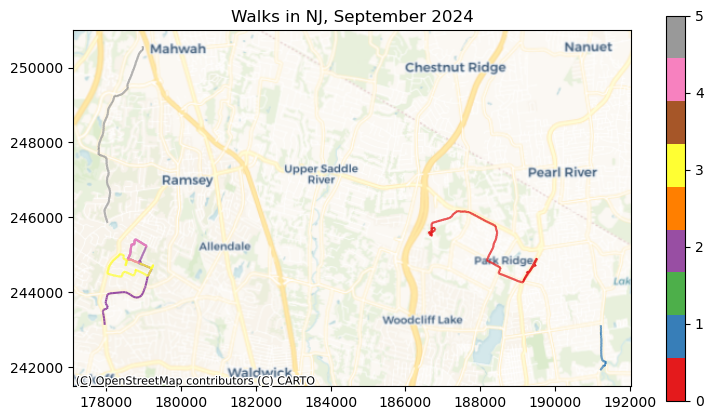

In [83]:
ax = tc_nj.plot(
	column='trajectory_id', 
	legend=True, figsize=(9,5), cmap='Set1')
ax.set_title('Walks in NJ, September 2024')
ctx.add_basemap(ax, crs=gdf_nj.crs,
				source=ctx.providers.CartoDB.Voyager);

In [13]:
traj_nj1 = tc_nj.trajectories[2]
print(traj_nj1)
print(traj_nj1.df.info())

Trajectory 2.0 (2024-09-07 21:20:23.975000 to 2024-09-07 22:03:42.022000) | Size: 267 | Length: 5173.1m
Bounds: (177912.1946985984, 243124.49067874879, 179216.17084672116, 245408.85808260852)
LINESTRING (178912.27991325516 244815.1747420021, 178912.27991325516 244815.1747420021, 178903.67850
<class 'geopandas.geodataframe.GeoDataFrame'>
DatetimeIndex: 267 entries, 2024-09-07 21:20:23.975000 to 2024-09-07 22:03:42.022000
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             267 non-null    object  
 1   Name           267 non-null    object  
 2   Lat            267 non-null    float64 
 3   Lon            267 non-null    float64 
 4   Elev           267 non-null    int64   
 5   Temp           267 non-null    float64 
 6   Weather        267 non-null    int64   
 7   geometry       267 non-null    geometry
 8   trajectory_id  267 non-null    float64 
dtypes: float64(4), geometry(1), int64(2), object

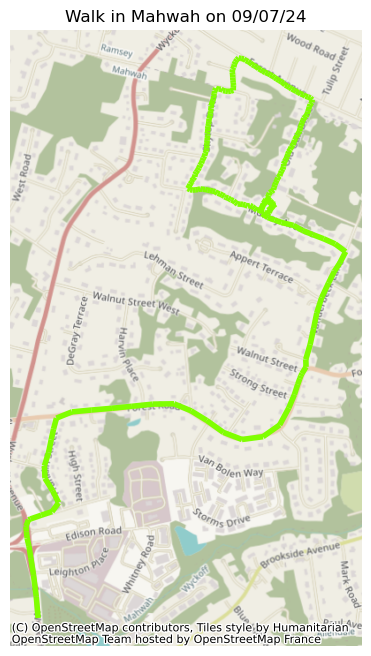

In [56]:
t_plot(traj_nj1, source=ctx.providers.OpenStreetMap.HOT);

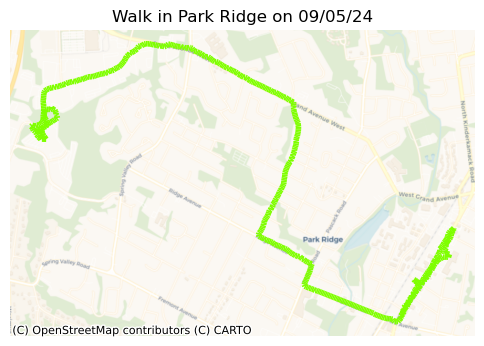

In [57]:
t_plot(
tc_nj.filter("Name", ["Park Ridge"])
     .trajectories[0]
);

In [16]:
tc_ny = mpd.TrajectoryCollection(
    gdf_ny, 'trajectory_id', 
    t='Time', x='Lon', y='Lat'
)
print(tc_ny)

TrajectoryCollection with 1 trajectories


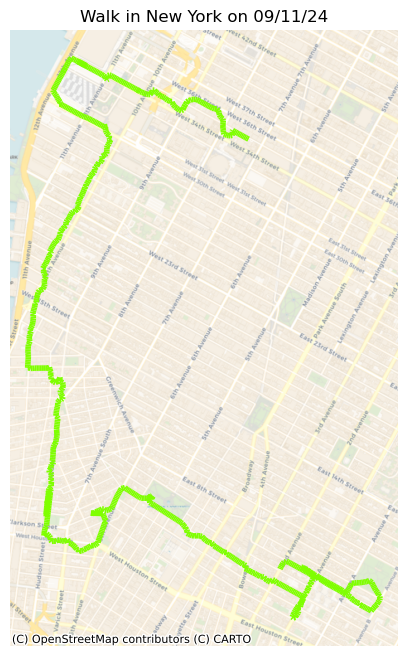

In [58]:
traj_ny = tc_ny.trajectories[0]
t_plot(traj_ny);

## Summary information

In [18]:
st = traj_ny.get_start_time()
sl = traj_ny.to_crs(4269).get_start_location()
et = traj_ny.get_end_time()
el = traj_ny.to_crs(4269).get_end_location()

In [19]:
print(f'''
            Time         Location (Lon/Lat)
            
    Start: {st.strftime('%X')}   {sl.coords[0]} degrees
    End:   {et.strftime('%X')}   {el.coords[0]}  degrees

    Duration:  {traj_ny.get_duration().seconds/60:.0f} minutes
    Distance:  {traj_ny.get_length(units='mi'):.2f} miles
    Direction: {traj_ny.get_direction():.0f} degrees
''')


            Time         Location (Lon/Lat)
            
    Start: 17:43:42   (-73.991157, 40.752025) degrees
    End:   20:49:09   (-73.98894, 40.726903)  degrees

    Duration:  185 minutes
    Distance:  6.69 miles
    Direction: 176 degrees



## Location, location

>Where was I at?

In [112]:
t = datetime(2024, 9, 11, 18)
t2 = t + timedelta(minutes=45)
print(f'''
    Nearest:      {traj_ny.to_crs(4269)
                    .get_position_at(t, method='nearest')}
    Interpolated: {traj_ny.to_crs(4269)
                    .get_position_at(t, method='interpolated')}
    Previous row: {traj_ny.to_crs(4269)
                    .get_position_at(t, method='ffill')}
    Next row:     {traj_ny.to_crs(4269)
                    .get_position_at(t, method='bfill')}
''')


    Nearest:      POINT (-74.003574 40.756368)
    Interpolated: POINT (-74.00361304734385 40.75638409846633)
    Previous row: POINT (-74.003688 40.756415)
    Next row:     POINT (-74.003574 40.756368)



In [85]:
point = traj_ny.get_position_at(t, method='interpolated')
point_up = traj_ny.to_crs(4269).get_position_at(t, method='interpolated')
point2 = traj_ny.get_position_at(t2, method='interpolated')
point2_up = traj_ny.to_crs(4269).get_position_at(t2, method='interpolated')

rg = reverse_geocode(
    [point_up, point2_up], provider="nominatim", user_agent="biscotty", timeout=10
)

rg = rg.to_crs(32111)

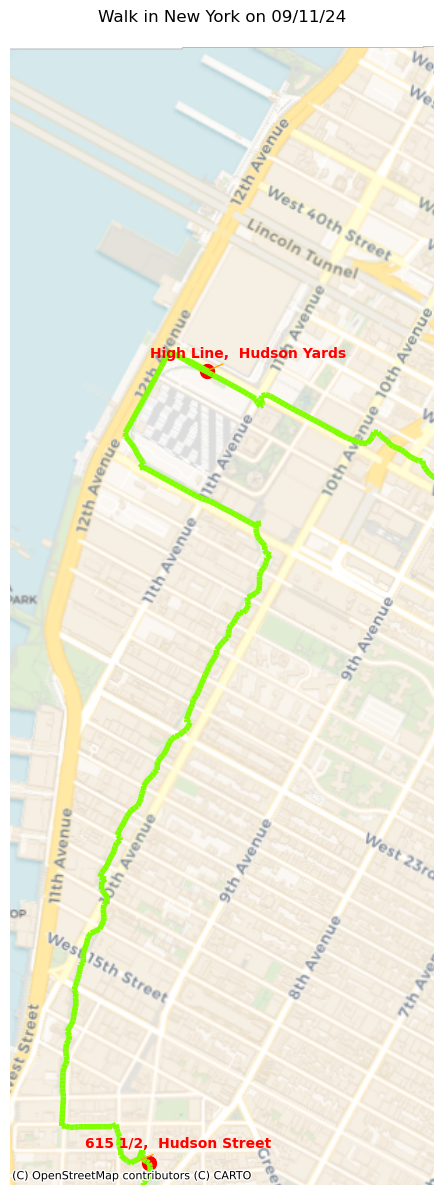

In [86]:
f, ax = t_plot(traj_ny, figsize=(7,15))
gpd.GeoSeries(point).plot(ax=ax, color='red', markersize=100)
gpd.GeoSeries(point2).plot(ax=ax, color='red', markersize=100)
for x, y, label in zip(rg.geometry.x, rg.geometry.y, rg.address):
    ax.annotate(f'{label.split(',')[0]}, {label.split(',')[1]}', 
                xy=(x, y), **annot_props)
ax.set_ylim(211500, 214500)
ax.set_xlim(191400, 192500);

>Every 30 minutes

In [107]:
int_count = (et - st) // timedelta(seconds=(60*30))
int_length = (et - st) / int_count
intervals = [st + (i*int_length) for i in range(int_count)]

In [108]:
interval_points = [traj_ny.to_crs(4269).get_position_at(t, method='interpolated') 
                   for t in intervals]

In [109]:
rg = reverse_geocode(
    interval_points, provider="nominatim", user_agent="biscotty", timeout=10
)

rg = rg.to_crs(32111)

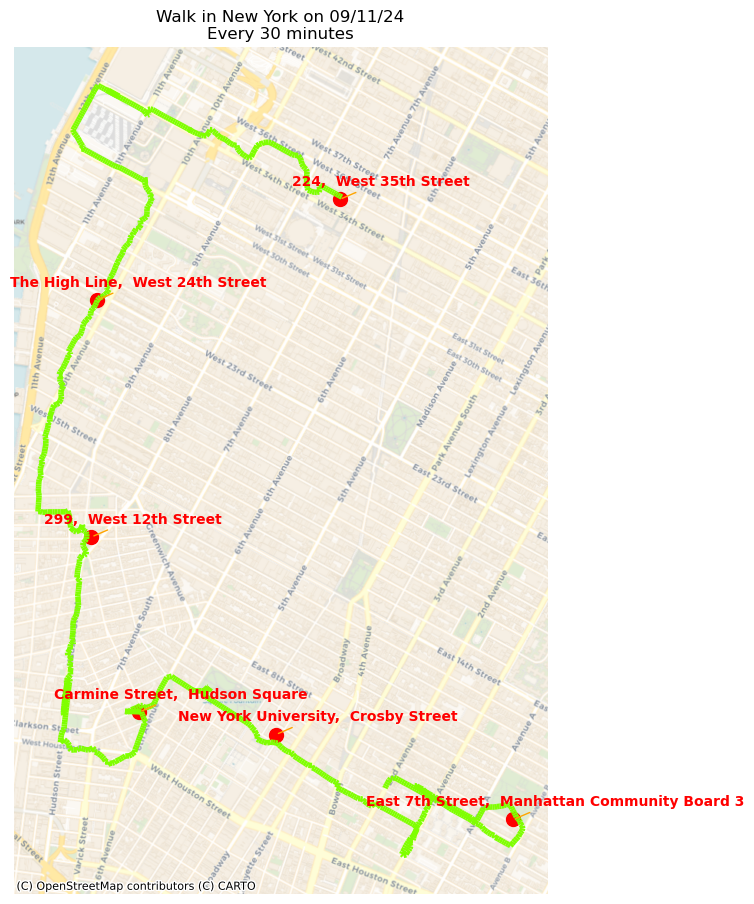

In [106]:
f, ax = t_plot(traj_ny, figsize=(7,11))
rg.plot(ax=ax, c='r', markersize=100)
for x, y, label in zip(rg.geometry.x, rg.geometry.y, rg.address):
    ax.annotate(f'{label.split(',')[0]}, {label.split(',')[1]}', 
                xy=(x, y), **annot_props)
ax.set_title(ax.get_title() + f'\nEvery 30 minutes');

>How far from?

In [23]:
addresses = [{
                'id': 1,
                'name': "The Strand", 
                'addr': "828 Broadway, New York, NY 10003"
            }, 
            {
                'id': 2,
                'name': "Barnes and Noble", 
                'addr': "33 East 17th Street, 10003, New York"
            }]
add_df = pd.DataFrame(addresses)
print(add_df)

   id              name                                  addr
0   1        The Strand      828 Broadway, New York, NY 10003
1   2  Barnes and Noble  33 East 17th Street, 10003, New York


In [24]:
geo = geocode(
    add_df['addr'], 
    provider='nominatim', user_agent='biscotty', 
    timeout=10
)
geo.head()

geometry  \
0  POINT (-73.99094 40.73328)   
1   POINT (-73.9896 40.73693)   

                                             address  
0  Strand Bookstore, 828, Broadway, University Vi...  
1  Barnes & Noble, 33, East 17th Street, Union Sq...

In [25]:
print(geo)

                     geometry  \
0  POINT (-73.99094 40.73328)   
1   POINT (-73.9896 40.73693)   

                                             address  
0  Strand Bookstore, 828, Broadway, University Vi...  
1  Barnes & Noble, 33, East 17th Street, Union Sq...  


In [26]:
book_stores = geo.join(add_df).to_crs(32111)
print(book_stores)

                        geometry  \
0  POINT (192997.822 211055.516)   
1  POINT (193108.568 211461.041)   

                                             address  id              name  \
0  Strand Bookstore, 828, Broadway, University Vi...   1        The Strand   
1  Barnes & Noble, 33, East 17th Street, Union Sq...   2  Barnes and Noble   

                                   addr  
0      828 Broadway, New York, NY 10003  
1  33 East 17th Street, 10003, New York  


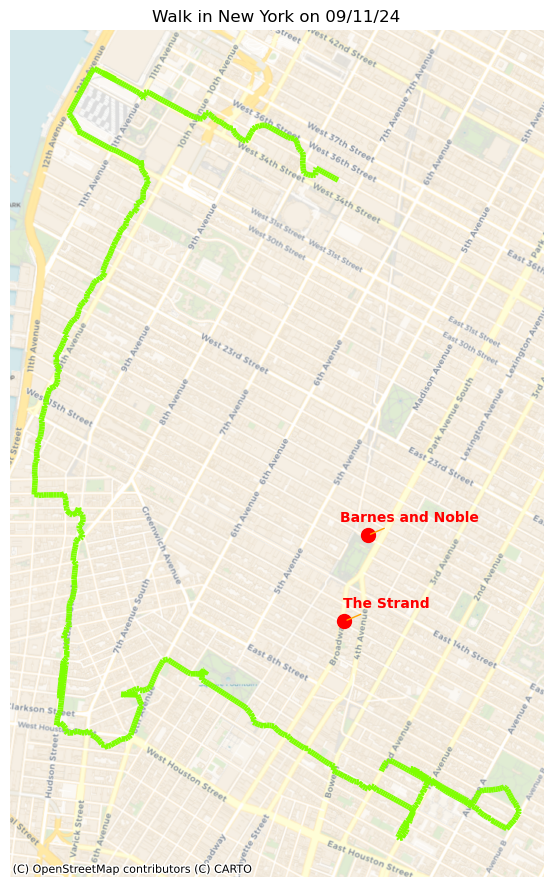

In [81]:
f, ax = t_plot(traj_ny, figsize=(7,11))
book_stores.plot(ax=ax, color='red', markersize=100)
for x, y, label in zip(book_stores.geometry.x, book_stores.geometry.y, book_stores.name):
    ax.annotate(label, xy=(x,y), **annot_props)

In [28]:
dists_to = [traj_ny.distance(book_stores.loc[i, ['geometry']], 
                            units='mi')[0] 
            for i in range(len(book_stores))]
store_names = [book_stores.loc[i, 'name'] 
               for i in range(len(book_stores))]

In [29]:
for i in range(len(book_stores)):
    print(f'Closest distance to {store_names[i]} was {dists_to[i]:.1f} miles') 

Closest distance to The Strand was 0.4 miles
Closest distance to Barnes and Noble was 0.6 miles


## Stops

In [30]:
detector = mpd.TrajectoryStopDetector(traj_ny)

In [31]:
stop_time_ranges = detector.get_stop_time_ranges(
    min_duration=timedelta(seconds=120), 
    max_diameter=100
)
len(stop_time_ranges)

18

In [32]:
print(stop_time_ranges[0])

Traj 6.0: 2024-09-11 17:44:37.079000 - 2024-09-11 17:46:44.090000 (duration: 0 days 00:02:07.011000)


In [33]:
stop_points = detector.get_stop_points(
    min_duration=timedelta(seconds=120), max_diameter=100
)
len(stop_points)

18

In [34]:
stop_points = stop_points.set_crs(32111)
rg = reverse_geocode(
    stop_points.to_crs(4269).geometry, provider="nominatim", user_agent="biscotty", timeout=10
).to_crs(32111)

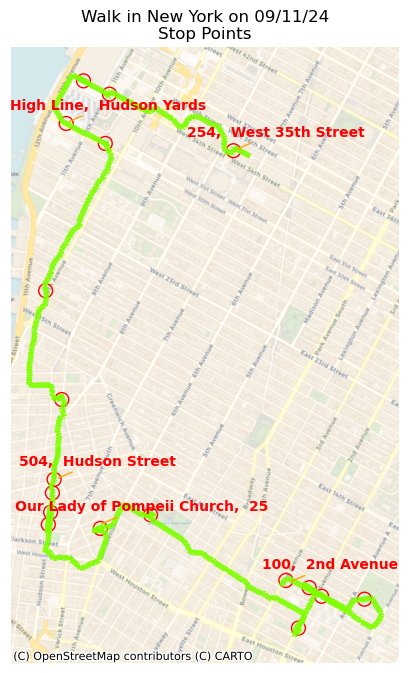

In [82]:
f, ax = t_plot(traj_ny)
stop_points.plot(ax=ax, color='none', markersize=100, ec='r')
point_labels = [0,3,7,11,17]
for (x, y), label in zip(
                    rg.iloc[point_labels].geometry.apply(
                        lambda p: p.coords[0]), 
                    rg.iloc[point_labels].address):
    ax.annotate(f'{label.split(',')[0]}, {label.split(',')[1]}', 
                xy=(x, y), **annot_props)
ax.set_title(ax.get_title() + f'\nStop Points');

In [36]:
m = traj_ny.explore(
    column="trajectory_id",
    tooltip="t",
    popup=True,
    style_kwds={"weight": 4},
    name="Time",
)

stop_points.explore(
    m=m,
    color="red",
    tooltip="stop_id",
    popup=True,
    marker_kwds={"radius": 10},
    name="Stop points",
)